# Estimating Gentrification using Street View Images and Embeddings

This script (initially produced by ChatGPT) does the following (_this was my query_):
 - Read a spatial boundary file (that I will hard code)
 - Obtain the road network (from OSM?) for that area
 - Generate sample points on the road network roughly X meters apart
 - At each sample point, download the most recent street images for that location (either a single 360 degree view of a few smaller images). Use whichever API service is the most appropriate for obtaining the images. Importantly please record the date that the image was taken.
 - For each image, calculate an embedding using an appropriate foundation model (one that has been pre-trained to distinguish street environments specifically). Please use Hugging Face libraries.
 - If necessary, calculate the mean embedding for each point (is this the best way to calculate a single embedding for a point represented by multiple images?)
 - Now, for each sampled point there will be a dataframe with information about the point and its embedding. Read another polygon spatial data file, that I will provide, which contains area-level estimates of gentrification.
 - Use point-in-polygon to get the gentrification for each point.
 - Use cross-validation to train a couple of ML models (probaly random forest, linear regression and a neural network) to estimate gentrification from the embedding vectors
 - Choose the best model and parameter configuration and test this model on some held-out data.

## Configuration and library loading

In [1]:
import os
from pathlib import Path
import requests
import pickle
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point, LineString
import numpy as np
import osmnx as ox


# Machine learning imports
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error

# Hugging Face Transformers for image embedding
from transformers import AutoImageProcessor, AutoModel  # will load a vision model

# Matplotlib for visualization
import matplotlib.pyplot as plt

# ----------------- Configuration -----------------
np.random.seed(42)           # set to None for non‑deterministic runs
data_dir = Path(os.path.join("..", "data", "airbnb-manchester"))
boundary_file = os.path.join(data_dir, "greater_manchester_lsoas.geojson")  # Path to boundary polygon file
gentrification_file = os.path.join("..", "gmgi_data", "lsoa_summary_jan25.csv")  # Path to polygons with gentrification index
#sample_spacing = 500.0   # distance in meters between sample points on roads
sample_spacing = 5000.0  # Very large for testing
n_directions = 4         # number of street view images per point (e.g., 4 cardinal directions)
image_size = "640x640"   # requested image resolution from Street View API
google_maps_api_key = "YOUR_GOOGLE_API_KEY_HERE"  # <-- Set your Google Street View API key here

# Create directories for caching if not exist
#Path(data_dir).mkdir(parents=True, exist_ok=True)
image_dir = Path(os.path.join(data_dir, "street_images"))
image_dir.mkdir(exist_ok=True)

## Data Loading

Merged neighbourhoods into single study-area boundary.
Bounds: (-2.73052481406758, 53.3281053809015, -1.90962093258169, 53.6857339236763)


/var/folders/bx/3j5z8qc50wl1tcff6xvbf2zh0000gs/T/ipykernel_60762/3352814336.py:8: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  boundary_polygon = boundary_neighs.unary_union  # shapely (multi)polygon


<Axes: >

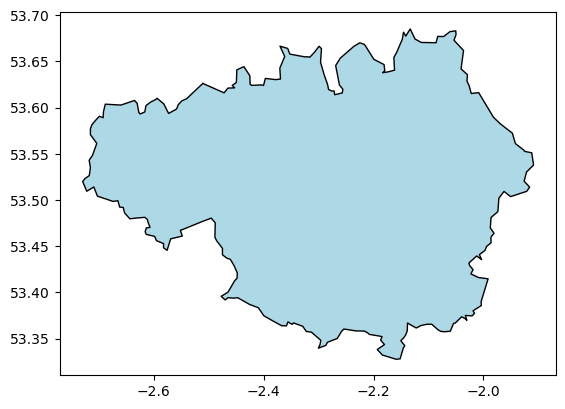

In [2]:
# --- Load neighbourhood polygons and dissolve to one study-area boundary ---
boundary_neighs = gpd.read_file(boundary_file)
# (Optional) keep original neighbourhoods for later mapping/stratified sampling
#neighbourhoods_gdf = boundary_neighs.copy()
# Make sure we're in WGS84 (lat/lon) for OSM and APIs
boundary_neighs = boundary_neighs.to_crs(epsg=4326)
# Dissolve: merge all geometries into one polygon (MultiPolygon possible)
boundary_polygon = boundary_neighs.unary_union  # shapely (multi)polygon
boundary_gdf = gpd.GeoDataFrame(
    data={'name': ['study_area']},
    geometry=[boundary_polygon],
    crs=boundary_neighs.crs
)

# TEMP! Just keep one LSOA for testing
#boundary_gdf = boundary_neighs.sample(1)

print("Merged neighbourhoods into single study-area boundary.")
print("Bounds:", boundary_polygon.bounds)
boundary_gdf.plot(color='lightblue', edgecolor='black')


## Get Road Network for the Area from OSM

In [3]:

# Cache file for road edges
roads_cache_file = data_dir / "road_network_edges.pkl"

if roads_cache_file.exists():
    print("Loading cached road network edges...")
    edges_gdf = pickle.load(open(roads_cache_file, "rb"))
else:
    # Retrieve road network graph from OSM within the boundary polygon
    print("Downloading road network from OSM...")
    road_graph = ox.graph_from_polygon(boundary_polygon, network_type='drive')
    # Convert graph edges to GeoDataFrame
    edges_gdf = ox.graph_to_gdfs(road_graph, nodes=False)
    # Save to cache
    pickle.dump(edges_gdf, open(roads_cache_file, "wb"))
    print(f"Road network saved to {roads_cache_file}")

print(f"Number of road segments: {len(edges_gdf)}")

Road network saved to ../data/airbnb-manchester/road_network_edges.pkl
Number of road segments: 232675


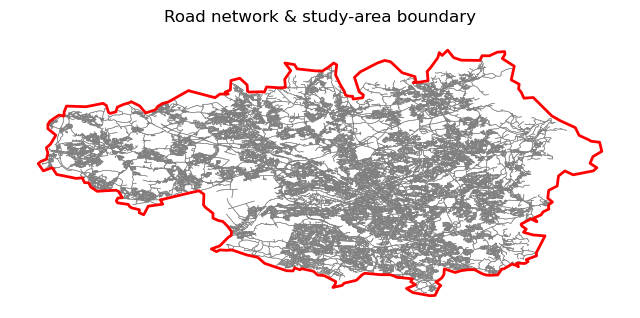

In [4]:
fig, ax = plt.subplots(figsize=(8, 8))

# Plot roads first (thin gray lines)
edges_gdf.plot(ax=ax, linewidth=0.4, color="gray")

# Plot the study-area outline on top (thicker red line)
boundary_gdf.boundary.plot(ax=ax, linewidth=2, edgecolor="red")

ax.set_title("Road network & study-area boundary", pad=12)
ax.set_axis_off()          # hides lat/lon ticks for a cleaner look
ax.set_aspect("equal")     # keeps the map from looking stretched

plt.show()

## Generate a Sample of Points along the road network

In [27]:
# Generate a sample of points along the street network (probabilistic)
# --------------------------------------------------------------------
# PARAMETERS
density_per_km = 0.1  # expected number of points per km of road
min_points_per_edge = 0  # allow very short edges to have none
max_points_per_edge = 10  # safety cap per edge
np.random.seed(42)  # set to None for non-deterministic runs

# Re-project roads to a metric CRS for length calculations
utm_crs = boundary_gdf.estimate_utm_crs()
edges_proj = edges_gdf.to_crs(utm_crs)

samples = []

# Loop over every edge geometry
for geom in edges_proj.geometry:
    if geom is None or geom.length == 0:
        continue

    length_m = geom.length
    expected = length_m / 1000 * density_per_km  # λ for Poisson
    n_points = np.random.poisson(expected)  # 0, 1, 2, …

    # Clip to limits
    n_points = max(min_points_per_edge, min(n_points, max_points_per_edge))

    if n_points == 0:
        continue

    # Evenly distribute interior points (skip endpoints)
    distances = np.linspace(0, length_m, n_points + 2)[1:-1]
    for d in distances:
        samples.append(geom.interpolate(d))

# Build GeoDataFrame of sample points (back to WGS-84 for API use)
points_gdf = (
    gpd.GeoDataFrame(geometry=gpd.GeoSeries(samples), crs=utm_crs)
    .to_crs(epsg=4326)
)
points_gdf["lon"] = points_gdf.geometry.x.round(6)
points_gdf["lat"] = points_gdf.geometry.y.round(6)
points_gdf = points_gdf.drop_duplicates(subset=["lat", "lon"]).reset_index(drop=True)

print(
    f"Generated {len(points_gdf)} points "
    f"with expected density {density_per_km} pts/km."
)

Generated 1815 points with expected density 0.1 pts/km.


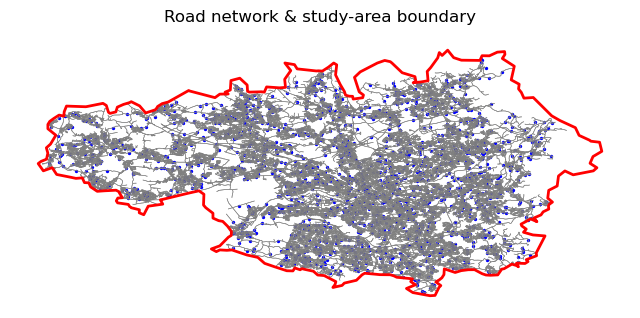

In [28]:
fig, ax = plt.subplots(figsize=(8, 8))

# Plot roads first (thin gray lines)
edges_gdf.plot(ax=ax, linewidth=0.4, color="gray")

# Plot the sample points
points_gdf.plot(ax=ax, color="blue", markersize=2, label="Sample Points")

# Plot the study-area outline on top (thicker red line)
boundary_gdf.boundary.plot(ax=ax, linewidth=2, edgecolor="red")

ax.set_title("Road network & study-area boundary", pad=12)
ax.set_axis_off()          # hides lat/lon ticks for a cleaner look
ax.set_aspect("equal")     # keeps the map from looking stretched

plt.show()

## Download street view images for each point

XXXX HERE. Finish configuring Street View API then download images for each point.